In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import random
import json
import datetime
import time
import pandas as pd
import torch.optim as optim
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [2]:
def prepare_data(df_path):
    df = pd.read_csv(df_path)

    df['bmi'].fillna(df['bmi'].mean(), inplace=True)
    df['smoking_status'].fillna(df['smoking_status'].mode()[0], inplace=True)

    label_encoders = {}
    categorical_cols = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
    for col in categorical_cols:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        label_encoders[col] = le

    X = df.drop(['stroke', 'id'], axis=1)
    y = df['stroke']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X1=X_train.copy(deep=True)
    X2=X_test.copy(deep=True)
    Y1=y_train.copy(deep=True)
    Y2=y_test.copy(deep=True)
    numerical_cols = ['age', 'avg_glucose_level', 'bmi']
    scaler = StandardScaler()
    X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
    X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

    return X_train, X_test, y_train, y_test, label_encoders,X,y,scaler,X1,X2,Y1,Y2

In [3]:
def train_evaluate_logistic(X_train, X_test, y_train, y_test, config,X,y,scaler,X1,X2,Y1,Y2):
    tracker = LogisticRegressionTracker()

    tracker.save_config(config)
    model = LogisticRegression(**config['model_params'])
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    from sklearn.metrics import roc_curve, auc
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'confusion_matrix': confusion_matrix(y_test, y_pred).tolist(),
        'feature_coefficients': model.coef_[0].tolist(),
        'feature_names': X_train.columns.tolist(),
        'fpr': fpr.tolist(),
        'tpr': tpr.tolist(),
        'auc': auc(fpr, tpr)
    }

    tracker.metrics.update(metrics)
    tracker.save_scaler(scaler)
    tracker.save_metrics()
    tracker.save_model(model)
    tracker.save_preprocessed_data(X,y,format='csv',name_prefix='encoded')
    tracker.save_preprocessed_data(X1,Y1,format='csv',name_prefix='train')
    tracker.save_preprocessed_data(X2,Y2,format='csv',name_prefix='test')
    tracker.save_preprocessed_data(X_train,y_train,format='csv',name_prefix='scaled_train')
    tracker.save_preprocessed_data(X_train,y_train,format='csv',name_prefix='scaled_test')
    plot_logistic_results(tracker, X_train, X_train.columns)

    return tracker.metrics



In [4]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

class LogisticRegressionTracker:
    def __init__(self, base_dir='model_outputs'):
        self.timestamp = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
        self.model_name = 'LogisticRegression'

        self.base_dir = Path(base_dir)
        self.run_dir = self.base_dir / f"{self.model_name}_{self.timestamp}"
        self.run_dir.mkdir(parents=True, exist_ok=True)

        self.metrics = {}
        self.feature_importance = {}

    def save_model(self, model):
        import joblib
        with open(self.run_dir / 'model.joblib', 'wb') as f:
            joblib.dump(model, f)

    def save_metrics(self):
        with open(self.run_dir / 'metrics.json', 'w') as f:
            json.dump(self.metrics, f, indent=4)

    def save_config(self, config):
        with open(self.run_dir / 'config.json', 'w') as f:
            json.dump(config, f, indent=4)
    def save_scaler(self,scaler):
        import joblib
        with open(self.run_dir / 'scaler.joblib', 'wb') as f:
            joblib.dump(scaler, f)
    
    def save_preprocessed_data(self, X, y=None, format='csv', name_prefix='preprocessed'):
       
        if format == 'csv':
            # Save features (X)
            if isinstance(X, pd.DataFrame):
                X.to_csv(self.run_dir / f'{name_prefix}_X.csv', index=False)
            else:
                pd.DataFrame(X).to_csv(self.run_dir / f'{name_prefix}_X.csv', index=False)

            # Save target (y) if provided
            if y is not None:
                if isinstance(y, pd.Series):
                    y.to_csv(self.run_dir / f'{name_prefix}_y.csv', index=False)
                else:
                    pd.Series(y).to_csv(self.run_dir / f'{name_prefix}_y.csv', index=False)


In [5]:
def plot_logistic_results(tracker, X_train, feature_names):
    plt.figure(figsize=(8, 6))
    sns.heatmap(tracker.metrics['confusion_matrix'],
                annot=True, fmt='d', cmap='Blues')
    plt.title('Logistic Regression Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.savefig(tracker.run_dir / 'confusion_matrix.png')
    plt.show()

    plt.figure(figsize=(12, 6))
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': np.abs(tracker.metrics['feature_coefficients'])
    }).sort_values('importance', ascending=True)

    plt.barh(range(len(importance_df)), importance_df['importance'])
    plt.yticks(range(len(importance_df)), importance_df['feature'])
    plt.title('Feature Importance in Logistic Regression')
    plt.xlabel('Absolute Coefficient Value')
    plt.tight_layout()
    plt.savefig(tracker.run_dir / 'feature_importance.png')
    plt.show()

    plt.figure(figsize=(8, 6))
    plt.plot(tracker.metrics['fpr'], tracker.metrics['tpr'],
             label=f'ROC Curve (AUC = {tracker.metrics["auc"]:.3f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.savefig(tracker.run_dir / 'roc_curve.png')
    plt.show()



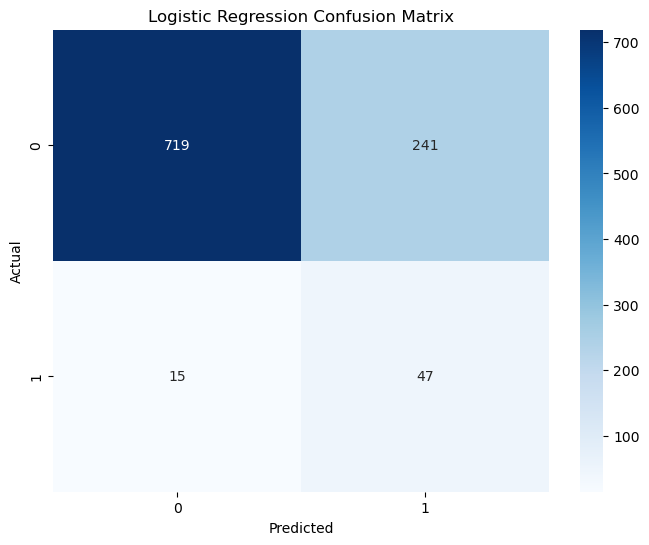

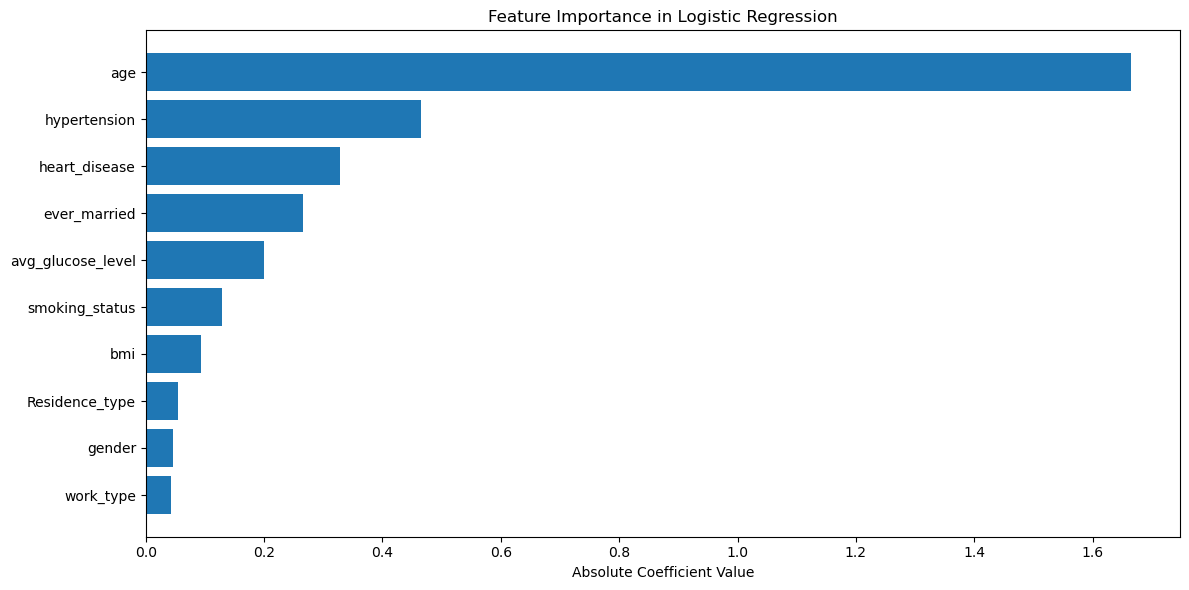

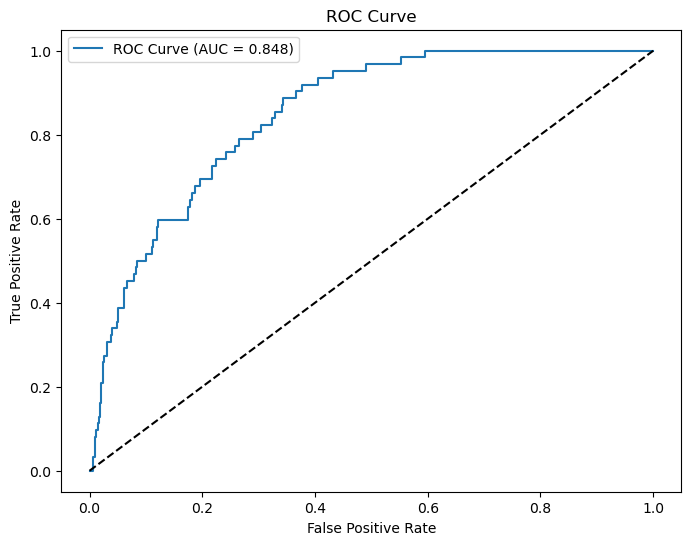


Logistic Regression Results:
Accuracy: 0.7495
Recall: 0.7581
Precision: 0.1632
AUC-ROC: 0.8482

Top 5 Most Important Features:
             feature  coefficient
1                age     1.664257
2       hypertension     0.464712
3      heart_disease     0.328255
4       ever_married    -0.265737
7  avg_glucose_level     0.199045


In [6]:
config = {
    'model_params': {
        'max_iter': 10000,
        'class_weight': 'balanced',
        'random_state': 42
    },
    'data_preprocessing': {
        'test_size': 0.2,
        'random_state': 42
    }
}

X_train, X_test, y_train, y_test, label_encoders , X , y ,scaler,X1,X2,Y1,Y2= prepare_data("healthcare-dataset-stroke-data (1).csv")
metrics = train_evaluate_logistic(X_train, X_test, y_train, y_test, config,X,y,scaler,X1,X2,Y1,Y2)

print("\nLogistic Regression Results:")
print(f"Accuracy: {metrics['accuracy']:.4f}")
print(f"Recall: {metrics['recall']:.4f}")
print(f"Precision: {metrics['precision']:.4f}")
print(f"AUC-ROC: {metrics['auc']:.4f}")

feature_importance = pd.DataFrame({
    'feature': metrics['feature_names'],
    'coefficient': metrics['feature_coefficients']
}).sort_values(by='coefficient', key=abs, ascending=False)

print("\nTop 5 Most Important Features:")
print(feature_importance.head())

In [7]:
class DenseNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(DenseNN, self).__init__()

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        self.batch_norm1 = nn.BatchNorm1d(128)
        self.batch_norm2 = nn.BatchNorm1d(64)
        self.batch_norm3 = nn.BatchNorm1d(32)

    def forward(self, x):
        x = self.flatten(x)
        x = self.relu(self.batch_norm1(self.fc1(x)))
        x = self.dropout(x)
        x = self.relu(self.batch_norm2(self.fc2(x)))
        x = self.dropout(x)
        x = self.relu(self.batch_norm3(self.fc3(x)))
        x = self.fc4(x)
        return x

class CNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(16, 32, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        self.pool = nn.MaxPool1d(2)

        conv_output_size = (input_size // 4) * 32

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(conv_output_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.dropout(x)
        x = self.flatten(x)

        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x



In [8]:
class ModelTracker:
    def __init__(self, model_name, base_dir='model_outputs'):
        self.timestamp = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
        self.model_name = model_name

        self.base_dir = Path(base_dir)
        self.run_dir = self.base_dir / f"{model_name}_{self.timestamp}"
        self.run_dir.mkdir(parents=True, exist_ok=True)

        self.metrics = {
            'train_loss': [],
            'train_accuracy': [],
            'train_f1': [],
            'test_accuracy': [],
            'test_f1': [],
            'epoch_times': []
        }

    def update_metrics(self, epoch_metrics):
        for key, value in epoch_metrics.items():
            self.metrics[key].append(value)

    def save_model(self, model, optimizer):
        checkpoint = {
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'metrics': self.metrics
        }
        torch.save(checkpoint, self.run_dir / 'model_checkpoint.pth')

    def save_metrics(self):
        with open(self.run_dir / 'metrics.json', 'w') as f:
            json.dump(self.metrics, f, indent=4)

    def save_config(self, config):
        with open(self.run_dir / 'config.json', 'w') as f:
            json.dump(config, f, indent=4)
    def save_preprocessed_data(self, X, y=None, format='csv', name_prefix='preprocessed'):
       
        if format == 'csv':
            
            if isinstance(X, pd.DataFrame):
                 X.to_csv(self.run_dir / f'{name_prefix}_X.csv', index=False)
            else:
                 pd.DataFrame(X).to_csv(self.run_dir / f'{name_prefix}_X.csv', index=False)

            
            if y is not None:
                if isinstance(y, pd.Series):
                    y.to_csv(self.run_dir / f'{name_prefix}_y.csv', index=False)
                else:
                    pd.Series(y).to_csv(self.run_dir / f'{name_prefix}_y.csv', index=False)
                
def plot_metrics(tracker, save_dir):

    plt.figure(figsize=(10, 6))
    plt.plot(tracker.metrics['train_loss'], label='Training Loss')
    plt.title(f'{tracker.model_name} Training Loss over Time')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(save_dir / 'training_loss.png')
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(tracker.metrics['train_accuracy'], label='Training Accuracy')
    plt.plot(tracker.metrics['test_accuracy'], label='Testing Accuracy')
    plt.plot(tracker.metrics['train_f1'], label='Training F1')
    plt.plot(tracker.metrics['test_f1'], label='Testing F1')
    plt.title(f'{tracker.model_name} Metrics Over Time')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.legend()
    plt.savefig(save_dir / 'metrics_comparison.png')
    plt.show()

    plt.figure(figsize=(8, 6))
    sns.heatmap(tracker.metrics['final_confusion_matrix'],
                annot=True, fmt='d', cmap='Blues')
    plt.title(f'{tracker.model_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.savefig(save_dir / 'confusion_matrix.png')
    plt.show()

    plt.figure(figsize=(8, 6))
    precision = tracker.metrics['precision_history'][-1]
    recall = tracker.metrics['recall_history'][-1]
    plt.scatter([recall], [precision], color='blue', s=100, label='Operating Point')
    plt.plot([0, 1], [precision, precision], '--', color='gray', label='Precision Line')
    plt.plot([recall, recall], [0, 1], '--', color='gray', label='Recall Line')
    plt.title(f'{tracker.model_name} Precision-Recall Point')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.grid(True)
    plt.legend()
    plt.savefig(save_dir / 'precision_recall.png')
    plt.show()

def train_evaluate_model(model, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor,
                        config):
    from sklearn.metrics import f1_score, precision_recall_curve

    tracker = ModelTracker(model.__class__.__name__)
    tracker.save_config(config)
    tracker.save_preprocessed_data(X_train_tensor,y_train_tensor,format='csv',name_prefix='Neural_train')
    tracker.save_preprocessed_data(X_test_tensor,y_test_tensor,format='csv',name_prefix='Neural_test')
    class_counts = torch.bincount(y_train_tensor)
    total_samples = len(y_train_tensor)
    class_weights = total_samples / (2 * class_counts)
    class_weights = class_weights / class_weights.sum()

    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'])

    precision_history = []
    recall_history = []

    for epoch in range(config['num_epochs']):
        model.train()
        start_time = datetime.datetime.now()

        optimizer.zero_grad()
        train_outputs = model(X_train_tensor)
        loss = criterion(train_outputs, y_train_tensor)
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            train_preds = torch.argmax(train_outputs, dim=1)
            train_acc = accuracy_score(y_train_tensor, train_preds)
            train_f1 = f1_score(y_train_tensor, train_preds)

            test_outputs = model(X_test_tensor)
            test_preds = torch.argmax(test_outputs, dim=1)
            test_acc = accuracy_score(y_test_tensor, test_preds)
            test_f1 = f1_score(y_test_tensor, test_preds)

            current_precision = precision_score(y_test_tensor, test_preds)
            current_recall = recall_score(y_test_tensor, test_preds)
            precision_history.append(current_precision)
            recall_history.append(current_recall)

        epoch_metrics = {
            'train_loss': loss.item(),
            'train_accuracy': train_acc,
            'train_f1': train_f1,
            'test_accuracy': test_acc,
            'test_f1': test_f1,
            'epoch_times': (datetime.datetime.now() - start_time).total_seconds()
        }
        tracker.update_metrics(epoch_metrics)

        if (epoch + 1) % 2 == 0:
            print(f'Epoch [{epoch+1}/{config["num_epochs"]}], '
                  f'Loss: {loss.item():.4f}, '
                  f'Train Acc: {train_acc:.4f}, '
                  f'Test Acc: {test_acc:.4f}, '
                  f'Train F1: {train_f1:.4f}, '
                  f'Test F1: {test_f1:.4f}')

    model.eval()
    with torch.no_grad():
        final_outputs = model(X_test_tensor)
        final_preds = torch.argmax(final_outputs, dim=1)

        final_metrics = {
            'accuracy': accuracy_score(y_test_tensor, final_preds),
            'recall': recall_score(y_test_tensor, final_preds),
            'precision': precision_score(y_test_tensor, final_preds),
            'f1_score': f1_score(y_test_tensor, final_preds),
            'final_confusion_matrix': confusion_matrix(y_test_tensor, final_preds).tolist(),
            'precision_history': precision_history,
            'recall_history': recall_history
        }

        tracker.metrics.update(final_metrics)
        tracker.save_metrics()
        tracker.save_model(model, optimizer)
        plot_metrics(tracker, tracker.run_dir)

        return tracker.metrics

def plot_model_comparison(cnn_metrics, dense_metrics, base_dir='model_outputs'):
    comparison_dir = Path(base_dir) / 'model_comparison'
    comparison_dir.mkdir(parents=True, exist_ok=True)

    metrics = ['accuracy', 'recall', 'precision', 'f1_score']
    values = {
        'CNN': [cnn_metrics[m] for m in metrics],
        'Dense NN': [dense_metrics[m] for m in metrics]
    }

    plt.figure(figsize=(12, 6))
    x = np.arange(len(metrics))

    plt.bar(x - width/2, values['CNN'], width, label='CNN')
    plt.bar(x + width/2, values['Dense NN'], width, label='Dense NN')

    plt.xlabel('Metrics')
    plt.ylabel('Score')
    plt.title('Model Performance Comparison')
    plt.xticks(x, metrics)
    plt.legend()
    plt.tight_layout()
    plt.savefig(comparison_dir / 'model_comparison.png')
    plt.show()

    comparison_results = {
        'CNN': cnn_metrics,
        'Dense NN': dense_metrics
    }
    with open(comparison_dir / 'comparison_results.json', 'w') as f:
        json.dump(comparison_results, f, indent=4)


Dataset Information:
Training samples: 4088
Testing samples: 1022
Number of features: 10
Class distribution in training set:
0    0.954256
1    0.045744
Name: stroke, dtype: float64

Training CNN Model
Epoch [2/400], Loss: 0.6799, Train Acc: 0.8023, Test Acc: 0.4472, Train F1: 0.1513, Test F1: 0.1776
Epoch [4/400], Loss: 0.6072, Train Acc: 0.7532, Test Acc: 0.4423, Train F1: 0.1830, Test F1: 0.1763
Epoch [6/400], Loss: 0.5741, Train Acc: 0.7982, Test Acc: 0.6928, Train F1: 0.1998, Test F1: 0.2559
Epoch [8/400], Loss: 0.5351, Train Acc: 0.6089, Test Acc: 0.6194, Train F1: 0.1736, Test F1: 0.2327
Epoch [10/400], Loss: 0.5155, Train Acc: 0.6977, Test Acc: 0.7495, Train F1: 0.2005, Test F1: 0.2686
Epoch [12/400], Loss: 0.5220, Train Acc: 0.7336, Test Acc: 0.6879, Train F1: 0.2160, Test F1: 0.2494
Epoch [14/400], Loss: 0.4969, Train Acc: 0.6561, Test Acc: 0.6732, Train F1: 0.1873, Test F1: 0.2477
Epoch [16/400], Loss: 0.5008, Train Acc: 0.6901, Test Acc: 0.7348, Train F1: 0.1976, Test F1: 

Epoch [160/400], Loss: 0.3985, Train Acc: 0.7657, Test Acc: 0.7476, Train F1: 0.2551, Test F1: 0.2456
Epoch [162/400], Loss: 0.3832, Train Acc: 0.7568, Test Acc: 0.7642, Train F1: 0.2526, Test F1: 0.2719
Epoch [164/400], Loss: 0.3903, Train Acc: 0.7806, Test Acc: 0.7661, Train F1: 0.2617, Test F1: 0.2601
Epoch [166/400], Loss: 0.3719, Train Acc: 0.7444, Test Acc: 0.7544, Train F1: 0.2487, Test F1: 0.2277
Epoch [168/400], Loss: 0.3825, Train Acc: 0.7321, Test Acc: 0.7358, Train F1: 0.2422, Test F1: 0.2458
Epoch [170/400], Loss: 0.3954, Train Acc: 0.7515, Test Acc: 0.7603, Train F1: 0.2463, Test F1: 0.2643
Epoch [172/400], Loss: 0.3821, Train Acc: 0.7598, Test Acc: 0.7603, Train F1: 0.2527, Test F1: 0.2508
Epoch [174/400], Loss: 0.3786, Train Acc: 0.7573, Test Acc: 0.7613, Train F1: 0.2508, Test F1: 0.2561
Epoch [176/400], Loss: 0.3829, Train Acc: 0.7546, Test Acc: 0.7652, Train F1: 0.2487, Test F1: 0.2547
Epoch [178/400], Loss: 0.3665, Train Acc: 0.7644, Test Acc: 0.7632, Train F1: 0.25

Epoch [322/400], Loss: 0.3152, Train Acc: 0.7801, Test Acc: 0.7779, Train F1: 0.2871, Test F1: 0.2357
Epoch [324/400], Loss: 0.3096, Train Acc: 0.7705, Test Acc: 0.7759, Train F1: 0.2785, Test F1: 0.2492
Epoch [326/400], Loss: 0.3161, Train Acc: 0.7774, Test Acc: 0.7896, Train F1: 0.2823, Test F1: 0.2509
Epoch [328/400], Loss: 0.3438, Train Acc: 0.8072, Test Acc: 0.7896, Train F1: 0.2939, Test F1: 0.2238
Epoch [330/400], Loss: 0.3006, Train Acc: 0.8001, Test Acc: 0.7847, Train F1: 0.3035, Test F1: 0.2414
Epoch [332/400], Loss: 0.3299, Train Acc: 0.7877, Test Acc: 0.7750, Train F1: 0.2850, Test F1: 0.2384
Epoch [334/400], Loss: 0.3223, Train Acc: 0.7891, Test Acc: 0.7984, Train F1: 0.2852, Test F1: 0.2482
Epoch [336/400], Loss: 0.3328, Train Acc: 0.8146, Test Acc: 0.7975, Train F1: 0.3059, Test F1: 0.2527
Epoch [338/400], Loss: 0.3067, Train Acc: 0.7867, Test Acc: 0.7750, Train F1: 0.2934, Test F1: 0.2434
Epoch [340/400], Loss: 0.3265, Train Acc: 0.7999, Test Acc: 0.7877, Train F1: 0.29

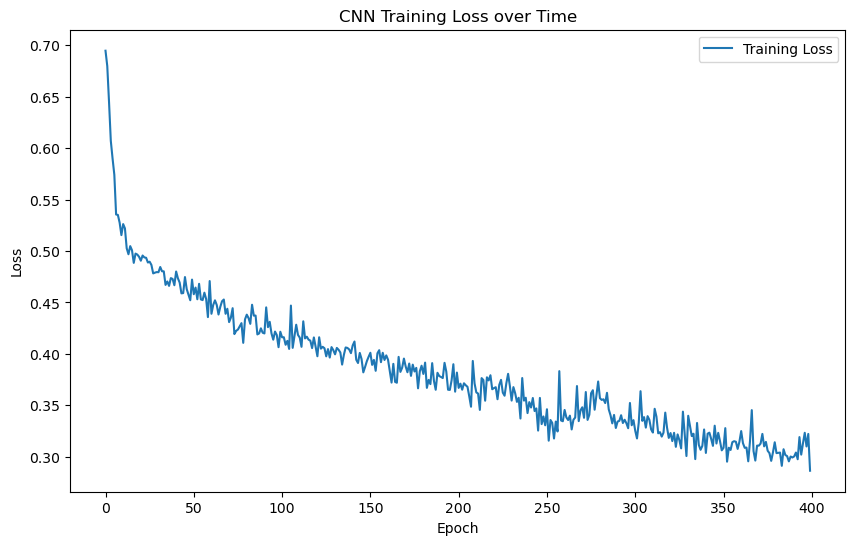

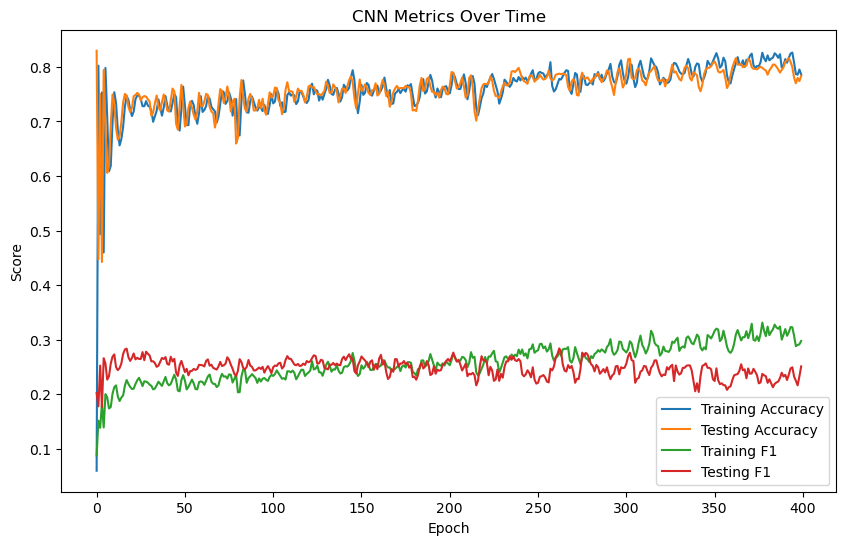

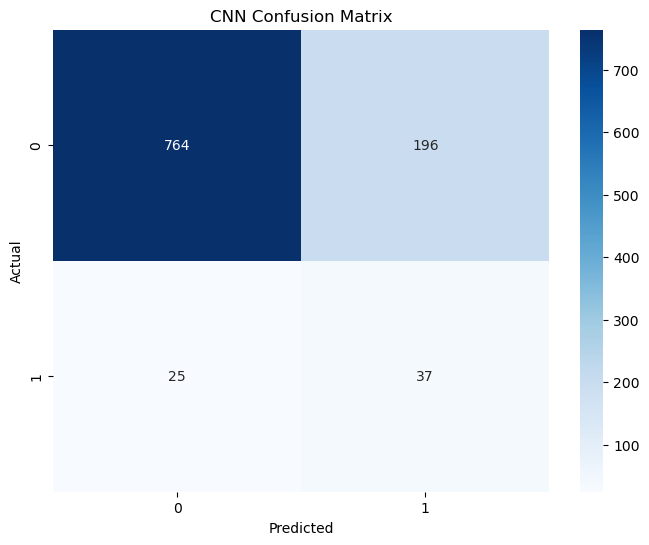

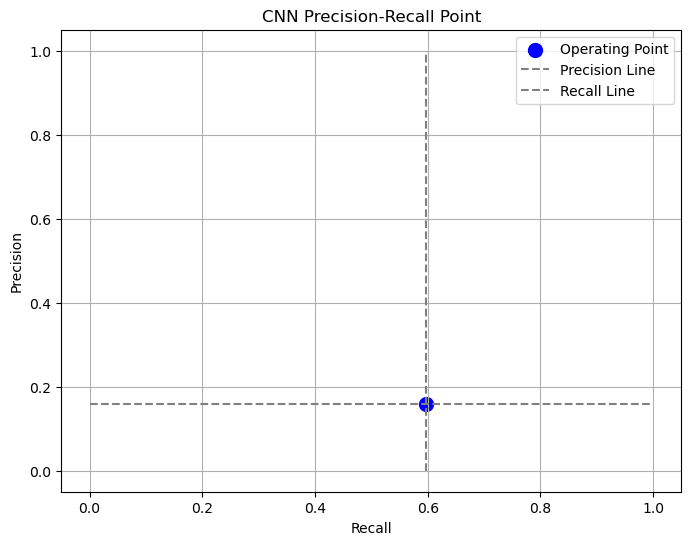

CNN Training Time: 66.46 seconds

Training Dense Neural Network
Epoch [2/400], Loss: 0.5882, Train Acc: 0.5582, Test Acc: 0.5049, Train F1: 0.1545, Test F1: 0.1917
Epoch [4/400], Loss: 0.5456, Train Acc: 0.6243, Test Acc: 0.5597, Train F1: 0.1768, Test F1: 0.2049
Epoch [6/400], Loss: 0.5132, Train Acc: 0.6649, Test Acc: 0.6262, Train F1: 0.1941, Test F1: 0.2298
Epoch [8/400], Loss: 0.4914, Train Acc: 0.6891, Test Acc: 0.6810, Train F1: 0.2021, Test F1: 0.2488
Epoch [10/400], Loss: 0.4843, Train Acc: 0.6974, Test Acc: 0.6928, Train F1: 0.2086, Test F1: 0.2488
Epoch [12/400], Loss: 0.4714, Train Acc: 0.6930, Test Acc: 0.6937, Train F1: 0.2011, Test F1: 0.2600
Epoch [14/400], Loss: 0.4637, Train Acc: 0.6915, Test Acc: 0.6947, Train F1: 0.2054, Test F1: 0.2607
Epoch [16/400], Loss: 0.4537, Train Acc: 0.6893, Test Acc: 0.6986, Train F1: 0.2033, Test F1: 0.2632
Epoch [18/400], Loss: 0.4604, Train Acc: 0.6972, Test Acc: 0.7094, Train F1: 0.2084, Test F1: 0.2667
Epoch [20/400], Loss: 0.4431, T

Epoch [164/400], Loss: 0.3065, Train Acc: 0.8256, Test Acc: 0.8160, Train F1: 0.3267, Test F1: 0.2824
Epoch [166/400], Loss: 0.2943, Train Acc: 0.8156, Test Acc: 0.8278, Train F1: 0.3145, Test F1: 0.2846
Epoch [168/400], Loss: 0.3071, Train Acc: 0.8156, Test Acc: 0.8307, Train F1: 0.3170, Test F1: 0.2881
Epoch [170/400], Loss: 0.2951, Train Acc: 0.8168, Test Acc: 0.8337, Train F1: 0.3185, Test F1: 0.2857
Epoch [172/400], Loss: 0.2996, Train Acc: 0.8141, Test Acc: 0.8258, Train F1: 0.3116, Test F1: 0.2705
Epoch [174/400], Loss: 0.3012, Train Acc: 0.8322, Test Acc: 0.8278, Train F1: 0.3340, Test F1: 0.2787
Epoch [176/400], Loss: 0.3048, Train Acc: 0.8136, Test Acc: 0.8249, Train F1: 0.3160, Test F1: 0.2753
Epoch [178/400], Loss: 0.3105, Train Acc: 0.8207, Test Acc: 0.8258, Train F1: 0.3269, Test F1: 0.2705
Epoch [180/400], Loss: 0.3176, Train Acc: 0.8300, Test Acc: 0.8170, Train F1: 0.3233, Test F1: 0.2780
Epoch [182/400], Loss: 0.2994, Train Acc: 0.8143, Test Acc: 0.8102, Train F1: 0.31

Epoch [328/400], Loss: 0.2564, Train Acc: 0.8735, Test Acc: 0.8464, Train F1: 0.4037, Test F1: 0.2629
Epoch [330/400], Loss: 0.2480, Train Acc: 0.8591, Test Acc: 0.8386, Train F1: 0.3833, Test F1: 0.2667
Epoch [332/400], Loss: 0.2360, Train Acc: 0.8589, Test Acc: 0.8434, Train F1: 0.3829, Test F1: 0.2661
Epoch [334/400], Loss: 0.2760, Train Acc: 0.8718, Test Acc: 0.8395, Train F1: 0.3907, Test F1: 0.2545
Epoch [336/400], Loss: 0.2203, Train Acc: 0.8635, Test Acc: 0.8376, Train F1: 0.3961, Test F1: 0.2655
Epoch [338/400], Loss: 0.2283, Train Acc: 0.8640, Test Acc: 0.8337, Train F1: 0.3917, Test F1: 0.2609
Epoch [340/400], Loss: 0.2489, Train Acc: 0.8711, Test Acc: 0.8356, Train F1: 0.3991, Test F1: 0.2566
Epoch [342/400], Loss: 0.2461, Train Acc: 0.8567, Test Acc: 0.8503, Train F1: 0.3819, Test F1: 0.2817
Epoch [344/400], Loss: 0.2414, Train Acc: 0.8603, Test Acc: 0.8532, Train F1: 0.3827, Test F1: 0.2718
Epoch [346/400], Loss: 0.2381, Train Acc: 0.8735, Test Acc: 0.8454, Train F1: 0.40

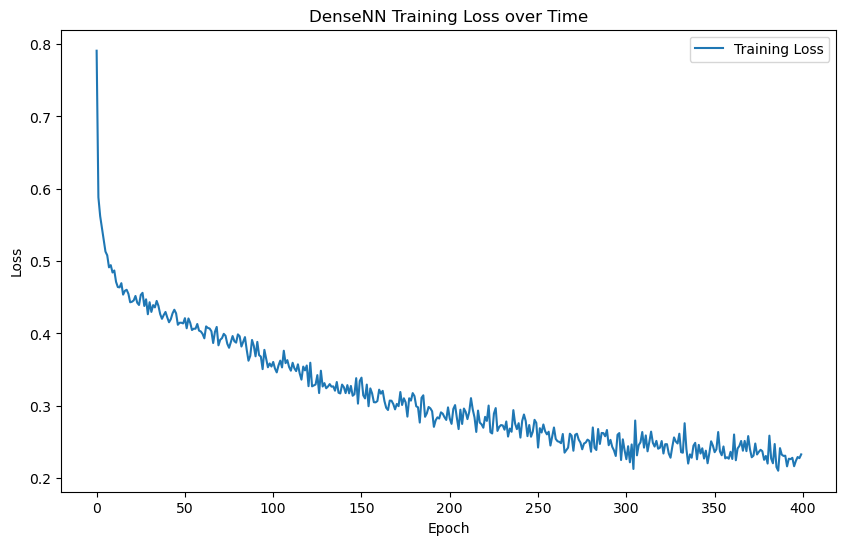

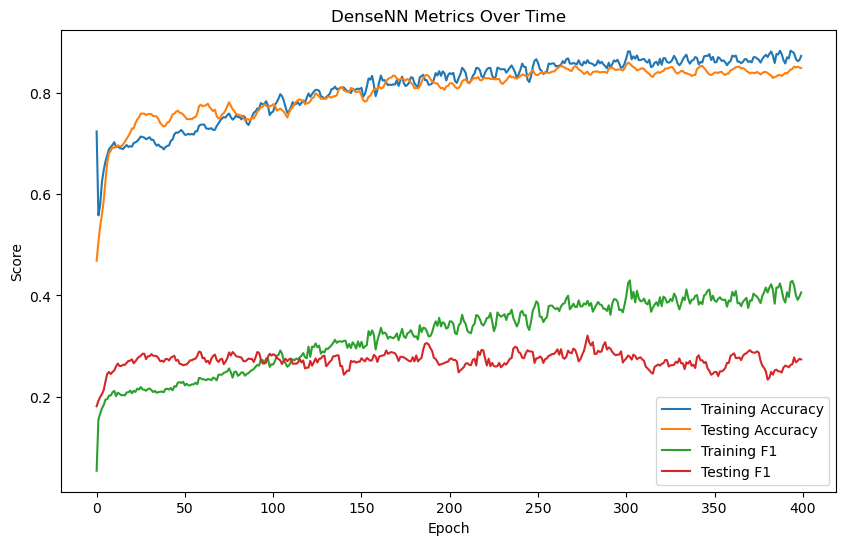

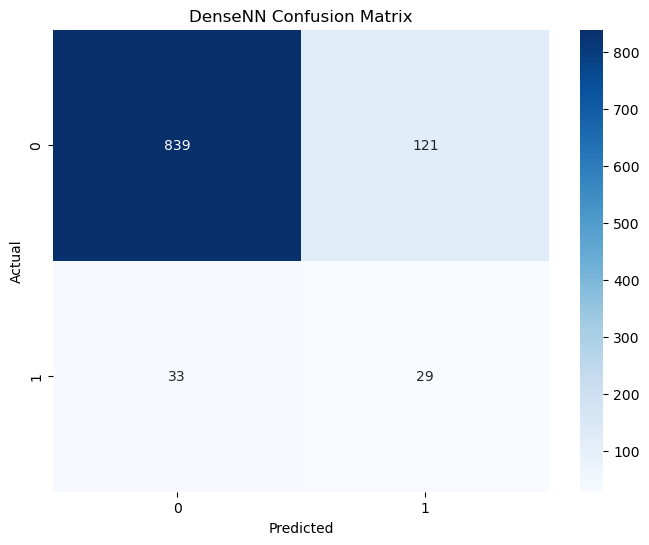

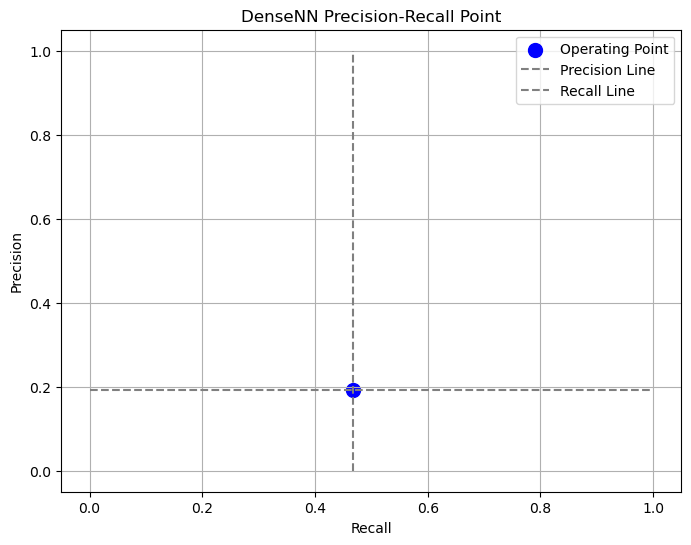

Dense Neural Network Training Time: 32.35 seconds

CNN Final Results:
----------------------------------------
Accuracy: 0.7838
Precision: 0.1588
Recall: 0.5968
F1 Score: 0.2508

Confusion Matrix:
[[764 196]
 [ 25  37]]

Dense Neural Network Final Results:
----------------------------------------
Accuracy: 0.8493
Precision: 0.1933
Recall: 0.4677
F1 Score: 0.2736

Confusion Matrix:
[[839 121]
 [ 33  29]]


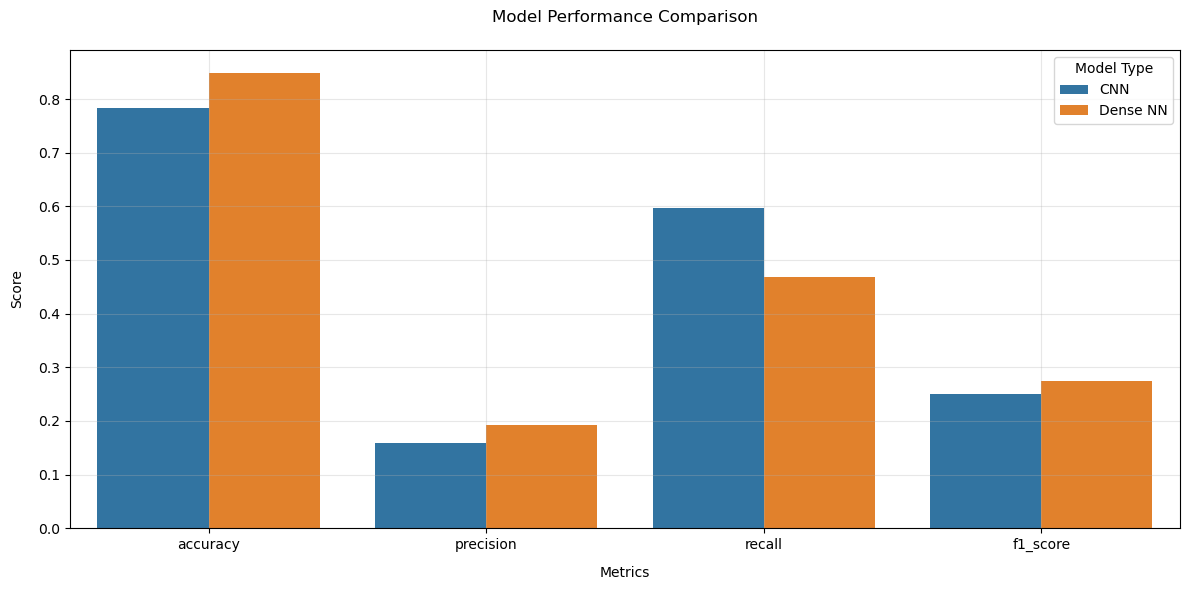


Summary Comparison Table:
   Metric      CNN  Dense NN
 Accuracy 0.783757  0.849315
Precision 0.158798  0.193333
   Recall 0.596774  0.467742
 F1 Score 0.250847  0.273585


In [9]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)






X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)


print("\nDataset Information:")
print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")
print(f"Number of features: {X_train.shape[1]}")
print(f"Class distribution in training set:")
print(pd.Series(y_train).value_counts(normalize=True))

config = {
    'num_epochs': 400,
    'learning_rate': 0.01,
    'batch_size': 32,
    'dropout_rate': 0.3,
    'hidden_sizes': [128, 64, 32],
    'conv_channels': [16, 32],
    'kernel_size': 3
}

input_size = X_train.shape[1]
num_classes = 2

print("\nTraining CNN Model")
cnn_model = CNN(input_size, num_classes)

start_time_cnn = time.time()
cnn_metrics = train_evaluate_model(cnn_model, X_train_tensor, y_train_tensor,
                                 X_test_tensor, y_test_tensor, config)
end_time_cnn = time.time()
print(f"CNN Training Time: {end_time_cnn - start_time_cnn:.2f} seconds")

print("\nTraining Dense Neural Network")
dense_model = DenseNN(input_size, num_classes)
start_time_dnn = time.time()
dense_metrics = train_evaluate_model(dense_model, X_train_tensor, y_train_tensor,
                                   X_test_tensor, y_test_tensor, config)
end_time_dnn = time.time()
print(f"Dense Neural Network Training Time: {end_time_dnn - start_time_dnn:.2f} seconds")

def print_model_results(model_name, metrics):
    print(f"\n{model_name} Final Results:")
    print("-" * 40)
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall: {metrics['recall']:.4f}")
    print(f"F1 Score: {metrics['f1_score']:.4f}")
    print("\nConfusion Matrix:")
    print(np.array(metrics['final_confusion_matrix']))

print_model_results("CNN", cnn_metrics)
print_model_results("Dense Neural Network", dense_metrics)

def plot_detailed_comparison(cnn_metrics, dense_metrics, base_dir='model_outputs'):
    comparison_dir = Path(base_dir) / 'model_comparison'
    comparison_dir.mkdir(parents=True, exist_ok=True)

    metrics = ['accuracy', 'precision', 'recall', 'f1_score']

    comparison_data = pd.DataFrame({
        'Metric': metrics * 2,
        'Model': ['CNN'] * len(metrics) + ['Dense NN'] * len(metrics),
        'Score': [cnn_metrics[m] for m in metrics] + [dense_metrics[m] for m in metrics]
    })

    plt.figure(figsize=(12, 6))
    sns.barplot(x='Metric', y='Score', hue='Model', data=comparison_data)
    plt.title('Model Performance Comparison', pad=20)
    plt.xlabel('Metrics', labelpad=10)
    plt.ylabel('Score', labelpad=10)
    plt.legend(title='Model Type')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(comparison_dir / 'detailed_comparison.png')
    plt.show()

    comparison_results = {
        'CNN': {metric: cnn_metrics[metric] for metric in metrics},
        'Dense NN': {metric: dense_metrics[metric] for metric in metrics}
    }

    with open(comparison_dir / 'detailed_comparison.json', 'w') as f:
        json.dump(comparison_results, f, indent=4)

plot_detailed_comparison(cnn_metrics, dense_metrics)

summary_data = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'CNN': [cnn_metrics[m] for m in ['accuracy', 'precision', 'recall', 'f1_score']],
    'Dense NN': [dense_metrics[m] for m in ['accuracy', 'precision', 'recall', 'f1_score']]
})

print("\nSummary Comparison Table:")
print(summary_data.to_string(index=False))

In [ ]:
def res(request):
    age=int(request.GET['age'])
    gen=int(request.GET['gender'])
    hdi=int(request.GET['heartdisease'])
    hpt=int(request.GET['hypertension'])
    mar=int(request.GET['maritalstatus'])
    wor=int(request.GET['worktype'])
    bmi=float(request.GET['bmi'])
    smoke=int(request.GET['smoking'])
    res=int(request.GET['residence'])
    glu=float(request.GET['glu'])
    sc=scaler.transform([[age,glu,bmi]])
    data=[[gen,sc[0][0],hpt,hdi,mar,wor,res,sc[0][1],sc[0][2],smoke]]
    lr_probs=model.predict_proba(data)[:, 1]
    pred1=model.predict(data)
    data1 = torch.tensor(data, dtype=torch.float32)
    test_outputs = dense_model(data1)
    DNN_probs= torch.softmax(test_outputs, dim=1)[:, 1].detach().numpy()
    test_preds = torch.argmax(test_outputs, dim=1)
    test_outputs_CNN = CNN_model(data1)
    CNN_probs = torch.softmax(test_outputs_CNN, dim=1)[:, 1].detach().numpy()
    test_preds_CNN = torch.argmax(test_outputs_CNN, dim=1)
    if lr_probs > 0.3:
        if 0.4 <DNN_probs < 0.6:
            final_pred = int(CNN_probs > 0.5)
        else:
            final_pred = int(DNN_probs > 0.5)
    else:
        final_pred = 0  
    if final_pred==0:
        hs=0
    else:
        hs=1
    return render(request,'res.html',{'pr':hs})